In [1]:
using QuantumBayesian
using DifferentialEquations
using PyPlot

# Julia Stochastic Differential Equation Test

**Justin Dressel**, Dec 6, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the built-in SDE solvers in the [DifferentialEquations](https://juliadiffeq.github.io/DiffEqDocs.jl/latest/tutorials/sde_example.html) package for Julia produce sensible results for even the simplest quantum problem of monitoring a single observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z observable.

### Qubit Hilbert Space

In [2]:
q = qubit()

QuantumBayesian.QFactor: Qubit
Dims  : 2
Ops   : "d", "y", "x", "u", "z", "i"


### Global Constants

In [3]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
Γ = 1/(2*τ);     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 3*τ);  # Time duration of simulation;

### Common Trajectory and Plotting Code

In [4]:
# Hamiltonian
H = (Ω/2)*q("y");

# Measurement dephasing
DM = sqrt(Γ/2)*q("z");

# Superoperators
dm = diss(DM)
mm = inn(sqrt(1/2)*DM)

# Deterministic part of evolution (Lindblad equation)
dρdt(t, ρ) = -im*comm(H, ρ) + dm(ρ)

# Ito stochastic part of evolution
dρdW(t, ρ) = mm(ρ)

# Initial ground state
ρ0 = full(ground(q));

In [5]:
# Plotting
function plot_solution(sol; plot_title="Monitored Rabi Oscillation")
    ts = linspace(T..., length(sol))
    info("Timesteps: ",length(sol))
    # Get Bloch components
    xs = zeros(Float64, ts) 
    ys = zeros(Float64, ts)
    zs = zeros(Float64, ts)
    for i in 1:length(sol)
        xs[i] = real(expect(sol[i], q("x")))
        ys[i] = real(expect(sol[i], q("y")))
        zs[i] = real(expect(sol[i], q("z")))
    end
    # Plot Bloch components vs. time
    p = plot(ts, xs, label=L"$x$")
    hold(true)
    plot(ts, ys, label=L"$y$")
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    plot(ts, zs, label=L"$z$")
    xlabel(L"$t/\tau$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
end;

## Simulation and Plots

Define the problem, with moderate duration to show expected behavior.

In [6]:
probsde = SDEProblem(dρdt, dρdW, ρ0, T);
probode = ODEProblem(dρdt, ρ0, T);

### Lindblad Euler evolution

Plot a reference unmonitored oscillation to verify Lindblad evolution is as expected. Use the explicitly first-order Euler method as a benchmark. The solution converges to acceptable precision by $dt=10^{-4}$.

  5.302345 seconds (13.91 M allocations: 838.826 MB, 5.71% gc time)


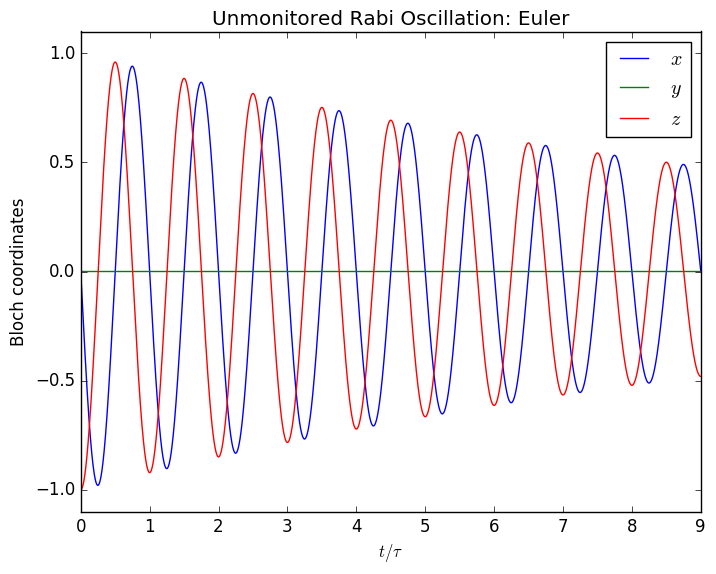

INFO: Timesteps: 90002


In [7]:
@time sol = solve(probode, Euler(), dt=1/10^4);

plot_solution(sol, plot_title="Unmonitored Rabi Oscillation: Euler")

Compare this to a 4th-order Runge-Kutta method with $dt=10^{-2}$, for completeness.

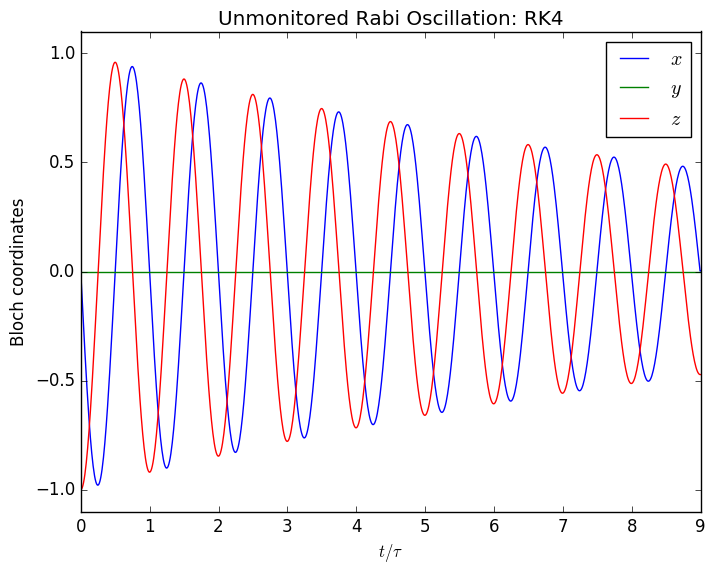

0.965977 seconds (1.13 M allocations: 54.562 MB, 3.19% gc time)


INFO: Timesteps: 902


In [8]:
@time sol = solve(probode, RK4(), dt=1/10^2);

plot_solution(sol, plot_title="Unmonitored Rabi Oscillation: RK4")

### Euler-Marayama SME

Now, try the Euler-Marayama method, which is also an explicit first-order time-stepped method. Try both $dt=10^{-4}$ and $dt=10^{-5}$ to check convergence.  **Importantly: any excursions beyond the bounds of $\pm 1$ are unphysical, and indicative of a numerical precision failure.**

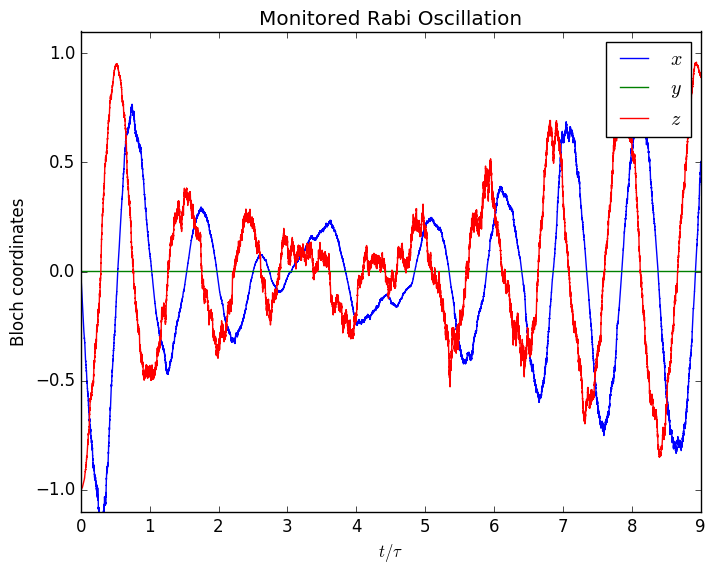

6.402732 seconds (17.36 M allocations: 1.112 GB, 7.26% gc time)


INFO: Timesteps: 90002


In [9]:
@time sol = solve(probsde, EM(), dt=1/10^4);

plot_solution(sol)

 40

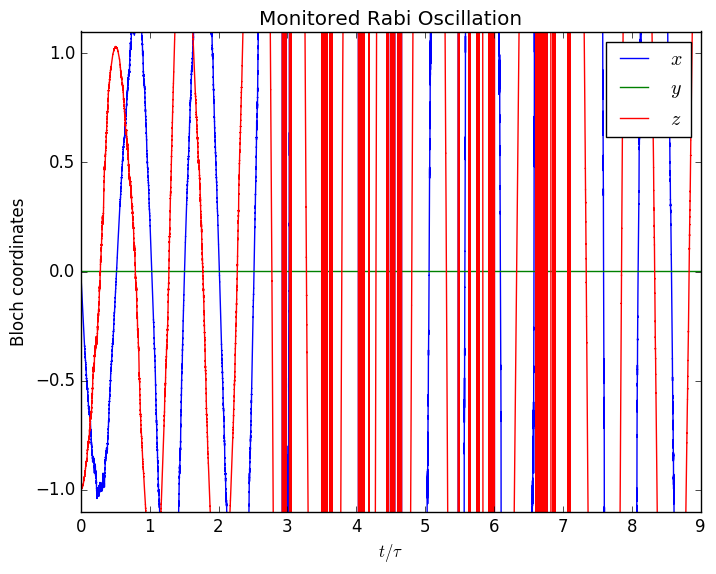

.035315 seconds (117.91 M allocations: 8.791 GB, 19.88% gc time)


INFO: Timesteps: 900002


In [10]:
@time sol = solve(probsde, EM(), dt=1/10^5);

plot_solution(sol)

Note that the first-order method yields unacceptable precision at $dt=10^{-4}$, which does not appreciably improve with an order of magnitude decrease in stepsize. This makes simulation of ensembles prohibitive.

### Rossler 1.5 SME

Next, try the explicitly order 1.5 Rossler method suitable for diagonal/scalar SDE, which should show improved precision over the order 1 EM method.

In [11]:
@time sol = solve(probsde, SRIW1(), dt=1/10^4);

plot_solution(sol)

LoadError: MethodError: no method matching isless(::Float64, ::Complex{Float64})[0m
Closest candidates are:
  isless(::Float64, [1m[31m::Float64[0m) at float.jl:283
  isless(::AbstractFloat, [1m[31m::AbstractFloat[0m) at operators.jl:40
  isless(::Real, [1m[31m::AbstractFloat[0m) at operators.jl:41
  ...[0m

In [12]:
@time sol = solve(probsde, SRIW1(), dt=1/10^5);

plot_solution(sol)

LoadError: MethodError: no method matching isless(::Float64, ::Complex{Float64})[0m
Closest candidates are:
  isless(::Float64, [1m[31m::Float64[0m) at float.jl:283
  isless(::AbstractFloat, [1m[31m::AbstractFloat[0m) at operators.jl:40
  isless(::Real, [1m[31m::AbstractFloat[0m) at operators.jl:41
  ...[0m

This also does not produce acceptable precision, despite the higher-order method.

### Rossler 2 SME
Next, try the Order-2 Rossler method that is suitable for additive noise.

In [13]:
@time sol = solve(probsde, SRA1(), dt=1/10^4);

plot_solution(sol)

LoadError: MethodError: no method matching isless(::Float64, ::Complex{Float64})[0m
Closest candidates are:
  isless(::Float64, [1m[31m::Float64[0m) at float.jl:283
  isless(::AbstractFloat, [1m[31m::AbstractFloat[0m) at operators.jl:40
  isless(::Real, [1m[31m::AbstractFloat[0m) at operators.jl:41
  ...[0m

In [14]:
@time sol = solve(probsde, SRA1(), dt=1/10^5);

plot_solution(sol)

LoadError: MethodError: no method matching isless(::Float64, ::Complex{Float64})[0m
Closest candidates are:
  isless(::Float64, [1m[31m::Float64[0m) at float.jl:283
  isless(::AbstractFloat, [1m[31m::AbstractFloat[0m) at operators.jl:40
  isless(::Real, [1m[31m::AbstractFloat[0m) at operators.jl:41
  ...[0m

This performance is notably better for $dt=10^{-5}$, but is still not an acceptable (i.e., trustable) precision. Substantially smaller time steps are needed before convergence to a sensible result, but even this code is 30 times slower that the naive Euler baseline for the nonstochastic integrator.

## Conclusions

None of the stochastic integration methods are suitable for integrating even the simplest problem of monitored qubit dynamics.

## Version Information

In [15]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz
  WORD_SIZE: 64
  BLAS: libopenblas (DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas
  LIBM: libm
  LLVM: libLLVM-3.7.1 (ORCJIT, haswell)


In [16]:
Pkg.installed("DifferentialEquations")

v"1.5.0"

In [17]:
Pkg.installed("PyPlot")

v"2.2.4"

In [18]:
Pkg.installed("QuantumBayesian")

v"0.1.0+"